# CrashStats Analysis

CrashStats data is provided to users by VicRoads for the purpose of supplying information about road crashes in Victoria for educational purposes.

The data provided allows users to analyse Victorian fatal and injury crash data based on time, location, conditions, crash type, road user type, object hit etc.

The data files are as follows:

Tables
- accident (basic accident details, time, severity, location)
- person (person based details, age, sex etc)
- vehicle (vehicle based data, vehicle type, make etc)
- accident_event (sequence of events e.g. left road, rollover, caught fire)
- road_surface_cond (whether road was wet, dry, icy etc)
- atmospheric_cond (rain, winds etc)
- sub_dca (detailed codes describing accident)
- accident_node (master location table - NB subset of accident table)
- Node Table with Lat/Long references

#### Objective

In this notebook we will run some rudimentary analyses on the data to try and gain insights into the data, that might help with modeling or other endeavors.

## Preparations

Importing necessary packages

In [2]:
# general packages
import os
import sys
import glob
import re

# data analysis packages
import numpy as np
import pandas as pd
import scipy.stats as st

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import ipywidgets

Reading all the files into Pandas DataFrames

In [6]:
# directory where files are stored
path = '../data'
csv_files = glob.glob(os.path.join(path, "*.csv"))

# reading files into dataframes; the relevant filenames are all caps
p = re.compile("([A-Z_]+)\.csv")
for file_path in csv_files:
    try:
        df_name = f'{p.search(file_path).groups()[0].lower()}_df'
    except:
        df_name = None
    print(df_name)
    if df_name is not None:
        locals()[df_name] = pd.read_csv(file_path)

accident_df


C:\Users\Ellie\AppData\Local\Temp\ipykernel_11916\3244363898.py:14: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  locals()[df_name] = pd.read_csv(file_path)


accident_chainage_df
accident_event_df
accident_location_df
atmospheric_cond_df
node_df
node_id_complex_int_id_df
person_df


C:\Users\Ellie\AppData\Local\Temp\ipykernel_11916\3244363898.py:14: DtypeWarning: Columns (6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  locals()[df_name] = pd.read_csv(file_path)


road_surface_cond_df
None
subdca_df
vehicle_df


C:\Users\Ellie\AppData\Local\Temp\ipykernel_11916\3244363898.py:14: DtypeWarning: Columns (3,25,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  locals()[df_name] = pd.read_csv(file_path)


We recieved a mixed type warning for several of the dataframes. Thankfully the warning tells us the column numbers, so we can easlity coerce them all the strings (and if they happen to actually be numerics we can deal with that later)

In [7]:
# dealing with multiples types issue
accident_df.iloc[:, [10,13]] = accident_df.iloc[:, [10,13]].applymap(lambda x: str(x))
person_df.iloc[:, [6,9,10,13]] = person_df.iloc[:, [6,9,10,13]].applymap(lambda x: str(x))
vehicle_df.iloc[:, [3,25,26,35,36]] = vehicle_df.iloc[:, [3,25,26,35,36]].applymap(lambda x: str(x))

## Data descriptions

We'll call the very useful Pandas function describe to get some initial stats on our data (there's a lot of stuff here, readers might want to just skip to the conclusions near the end of this section)

In [8]:
accident_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,203708,203708,T20060000010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCIDENTDATE,203708,5416,17/04/2015,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCIDENTTIME,203708,1440,16:00:00,3014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCIDENT_TYPE,203708.0,NaN,NaN,NaN,2.262106,2.002073,1.0,1.0,1.0,4.0,9.0
Accident Type Desc,203708,9,Collision with vehicle,126653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAY_OF_WEEK,203708.0,NaN,NaN,NaN,3.975283,1.99002,0.0,2.0,4.0,6.0,7.0
Day Week Description,203708,7,Friday,32240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DCA_CODE,203708.0,NaN,NaN,NaN,139.295487,26.479004,100.0,120.0,130.0,171.0,199.0
DCA Description,203708,81,REAR END(VEHICLES IN SAME LANE),32312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIRECTORY,201360,4,MEL,149505,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
accident_chainage_df.astype(str).describe(include='all').T

,count,unique,top,freq
Node Id,173557,136224,"25,961",9
Route No,173557,36853,2510.0,3293
Chainage Seq,173557,10,1.0,136223
Route Link No,173557,39013,25100207.0,786
Chainage,173557,36790,0.0,14353


In [10]:
accident_event_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,326638,203708,T20160000627,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVENT_SEQ_NO,326634.0,NaN,NaN,NaN,1.519211,0.829661,1.0,1.0,1.0,2.0,20.0
EVENT_TYPE,326634,10,C,223498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Event Type Desc,326638,11,Collision,223498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_1_ID,326634,15,A,237145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_1_COLL_PT,326634,16,9,125155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle 1 Coll Pt Desc,326638,17,Not known or Not Applicable,125155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_2_ID,326634,22,,172225,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_2_COLL_PT,326634,17,,172257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle 2 Coll Pt Desc,326638,17,,172261,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
accident_location_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,203708,203708,T20060000010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_ID,203708.0,NaN,NaN,NaN,190955.262096,151789.148066,-10.0,43723.0,218026.5,281585.25,666096.0
ROAD_ROUTE_1,202878.0,NaN,NaN,NaN,6440.84159,2990.242702,-1.0,4034.0,5784.0,9999.0,9999.0
ROAD_NAME,202702,14030,PRINCES,5209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROAD_TYPE,200309,83,ROAD,101946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROAD_NAME_INT,201886,21237,VICTORIA,1264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROAD_TYPE_INT,200211,110,ROAD,74946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISTANCE_LOCATION,202878.0,NaN,NaN,NaN,131.302394,412.515484,-1.0,0.0,14.0,82.0,63038.0
DIRECTION_LOCATION,202878,10,W,45521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NEAREST_KM_POST,45.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
atmospheric_cond_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,206958,203708,T20060018293,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATMOSPH_COND,206958.0,NaN,NaN,NaN,1.815407,2.175279,1.0,1.0,1.0,1.0,9.0
ATMOSPH_COND_SEQ,206958.0,NaN,NaN,NaN,0.880715,0.366231,0.0,1.0,1.0,1.0,4.0
Atmosph Cond Desc,206958,8,Clear,164227,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
node_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,221797,202854,T20190018371,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_ID,221797.0,NaN,NaN,NaN,186516.588894,151444.425516,4.0,42819.0,214818.0,279127.0,666055.0
NODE_TYPE,221797,4,N,116396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VICGRID94_X,221797.0,NaN,NaN,NaN,2498085.698196,69598.95863,2129296.529,2489777.957,2501426.886,2516734.634,2920148.029
VICGRID94_Y,221797.0,NaN,NaN,NaN,2419551.410123,61165.698421,2273613.61,2395091.547,2409167.477,2420158.986,2818209.194
LGA_NAME,221797,88,MELBOURNE,15568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LGA_NAME_ALL,221797,286,MELBOURNE,13353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REGION_NAME,221797,8,METROPOLITAN SOUTH EAST REGION,83886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEG_URBAN_NAME,221797,7,MELB_URBAN,144626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lat,221797.0,NaN,NaN,NaN,-37.722339,0.553918,-39.03232,-37.944574,-37.818243,-37.718671,-34.06238


In [14]:
node_id_complex_int_id_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,203996,203708,T20110031259,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NODE_ID,203996.0,NaN,NaN,NaN,190845.355139,151780.43892,-10.0,43723.0,217955.5,281534.5,666096.0
COMPLEX_INT_NO,21925.0,NaN,NaN,NaN,14195.563831,25424.644279,1000.0,5794.0,7095.0,9259.0,103396.0


In [15]:
person_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,490948,203708,T20130018492,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PERSON_ID,490948,116,A,201254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_ID,490948,22,A,267672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEX,490948,4,M,273439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,469319.0,NaN,NaN,NaN,37.348511,18.737616,0.0,23.0,34.0,50.0,109.0
Age Group,490948,14,30-39,84639,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INJ_LEVEL,490948,5,4,225265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inj Level Desc,490948,5,Not injured,225265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEATING_POSITION,469659,11,D,351229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HELMET_BELT_WORN,490948,10,1,278746,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
road_surface_cond_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,205030,203708,T20080021425,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SURFACE_COND,205030.0,NaN,NaN,NaN,1.591489,1.772907,1.0,1.0,1.0,1.0,9.0
Surface Cond Desc,205030,6,Dry,160269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SURFACE_COND_SEQ,205030.0,NaN,NaN,NaN,0.870907,0.351801,0.0,1.0,1.0,1.0,3.0


In [17]:
subdca_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,290966,197897,T20060036736,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUB_DCA_CODE,290966,121,NRQ,64699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUB_DCA_SEQ,290966.0,NaN,NaN,NaN,0.952091,0.802891,0.0,0.0,1.0,1.0,6.0
Sub Dca Code Desc,290966,114,Not Required,64699,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
vehicle_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ACCIDENT_NO,365242,203708,T20160000627,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_ID,365242,21,A,202912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_YEAR_MANUF,342384.0,NaN,NaN,NaN,1906.954653,428.611596,0.0,1997.0,2004.0,2009.0,3001.0
VEHICLE_DCA_CODE,365242,5,1,203430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INITIAL_DIRECTION,365242,9,S,62797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROAD_SURFACE_TYPE,365242.0,NaN,NaN,NaN,1.136967,0.763951,1.0,1.0,1.0,1.0,9.0
Road Surface Type Desc,365242,4,Paved,346744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REG_STATE,365242,12,V,325184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_BODY_STYLE,365242,136,SEDAN,166915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLE_MAKE,365242,631,TOYOTA,55984,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Notes
- The most natural target variable we have for a model is SEVERITY (accident_df), since it constitutes the most concise summary of the accident's outcome. 
- Other candidates for target variables include NO_PERSONS_KILLED and NO_PERSONS_INJ_2 (meaning severely injured). Another option is to use INJ_LEVEL (person_df), and make predictions per person rather than per accident
- There more more nodes than accidents, and the number of unique accidents in node_df is unequal to the total number of accidents. Is this noise or something else?
- COMPLEX_INT_NO only exists for around %10 of the data where the accident occured at a complex intersection. The actual intersection number probably won't tell us much, but the existence of it or lack thereof can be useful.
- Certain fields have extremely high cardinality (above 10,000). However, in ROAD_NAME for example, we see that the top level has over 5,000 rows (around 0.25% of the data). Possibly we can use this field if we only take the top N levels and bin all the others in a new category labeled "Other". Another example of a field like this is VEHICLE_MAKE (631 levels).

Just in case the datetime columns ACCIDENTDATE and ACCIDENTTIME aren't datetime type, let's make them so

In [19]:
accident_df['ACCIDENTDATE'] = pd.to_datetime(accident_df['ACCIDENTDATE'], infer_datetime_format=True)
accident_df['ACCIDENTTIME'] = pd.to_datetime(accident_df['ACCIDENTTIME'], infer_datetime_format=True)

## Analysis

We're now ready to make some inquiries from our data. Here's a list of questions we'll try to cover (but not limit ourselves to):
- How has the number of accidents changed over time?
- What are the distributions among accidents for variables like number of events, number of persons, etc?
- What's the frequency of each severity?
- How do factors like date/time, age, speed zone, etc interact with severity and/or fatality?
- How do the different levels of injury correlate?

### Accidents over time

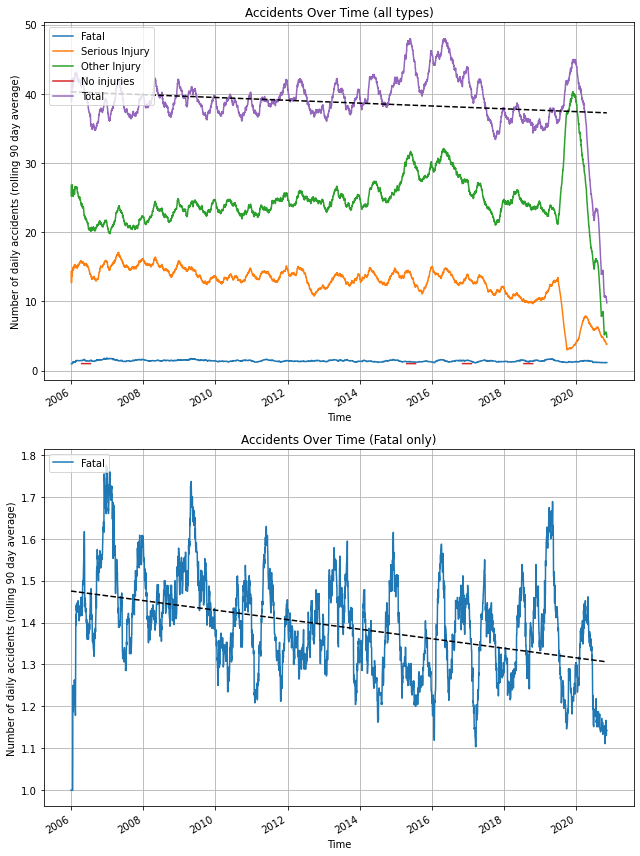

In [20]:
# time series data. calculating 90 day rolling average for each severity level
df_plot = accident_df.groupby(['SEVERITY', pd.Grouper(key='ACCIDENTDATE', freq='1D')]).size().reset_index().pivot(
    columns='SEVERITY', index='ACCIDENTDATE', values=0)
df_plot = df_plot.rolling('90D').mean()
df_plot['Total'] = df_plot.T.sum()
df_plot.rename(columns={1:'Fatal', 2:'Serious Injury', 3:'Other Injury', 4:'No injuries'}, inplace=True)

# data for trend lines
df_dates = mdates.date2num(df_plot.index)
total_z = np.polyfit(df_dates, df_plot['Total'], 1)
fatal_z = np.polyfit(df_dates, df_plot['Fatal'], 1)
total_trend = np.poly1d(total_z)
fatal_trend = np.poly1d(fatal_z)

fig, ax = plt.subplots(2,1, figsize=(9,12))

# all accidents time series
df_plot.iloc[3:,:].plot(ax=ax[0], grid=True);
# total accidents trendline
ax[0].plot(df_dates, total_trend(df_dates), "k--")
ax[0].legend(loc='upper left');
ax[0].set_title('Accidents Over Time (all types)');
ax[0].set_xlabel('Time');
ax[0].set_ylabel('Number of daily accidents (rolling 90 day average)');

# fatal accidents time series
df_plot['Fatal'].plot(ax=ax[1], grid=True);
# fatal accidents trendline
ax[1].plot(df_dates, fatal_trend(df_dates), "k--")
ax[1].legend(loc='upper left');
ax[1].set_title('Accidents Over Time (Fatal only)');
ax[1].set_xlabel('Time');
ax[1].set_ylabel('Number of daily accidents (rolling 90 day average)');

fig.tight_layout()
plt.savefig('../figs/accidents_over_time.png')

#### Notes
- Nice big drop around the COVID lockdowns of 2020, no surprise there. Hard to tell if the corresponding reduction in fatal accidents is also due to the lockdowns, or if it's just a natural fluctuation (there are some time). It seems that serious injury accidents increase in this period, which seems paradoxical. Could this be because of higher speeds due to the empty roads?
- In 2019, there's a sharp rise in other injury and total at the same time as a sharp decline in serious injury. Coincidence? Change of definition?
- We're missing populations data, which is crucial as context for these trends in accidents. The number of accidents appears to be generally increasing, but is this simply because there are more people using the roads? It would be beneficial  to study the correlation between the trend in population and the trend in accidents


Sticking with the theme of time related analysis, let's look at how accidents distribute over the course of a week. We'll generate two heatmaps per day of week and hour: 
1) For all accidents
2) For fatal accidents

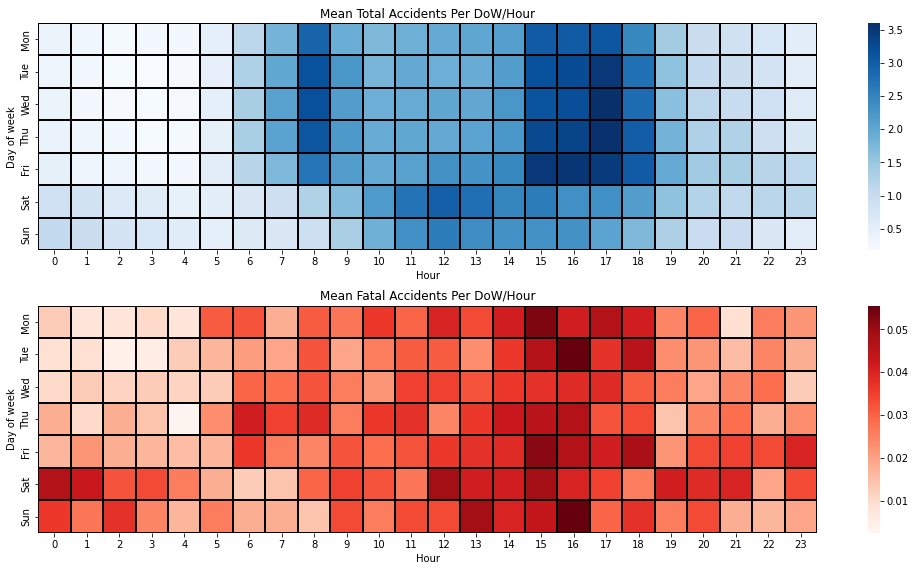

In [21]:
number_of_weeks = (accident_df['ACCIDENTDATE'].max() - accident_df['ACCIDENTDATE'].min()) / np.timedelta64(7, 'D')

# creating weekly mean chart for all accidents
dow_time_df = accident_df.groupby([accident_df['ACCIDENTDATE'].dt.dayofweek, 
                                   accident_df['ACCIDENTTIME'].dt.hour], as_index=False).size().pivot(
    columns='ACCIDENTTIME', index='ACCIDENTDATE')
dow_time_df.columns = dow_time_df.columns.droplevel(0)
dow_time_df.rename(index = dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])), inplace=True)
dow_time_df = dow_time_df / number_of_weeks

# creating weekly mean chart for fatal accidents
fatal_dow_time_df = accident_df[accident_df['SEVERITY']==1].groupby([accident_df['ACCIDENTDATE'].dt.dayofweek, 
                                   accident_df['ACCIDENTTIME'].dt.hour], as_index=False).size().pivot(
    columns='ACCIDENTTIME', index='ACCIDENTDATE')
fatal_dow_time_df.columns = fatal_dow_time_df.columns.droplevel(0)
fatal_dow_time_df.rename(index = dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])), inplace=True)
fatal_dow_time_df = fatal_dow_time_df / number_of_weeks

fig, ax = plt.subplots(2,1,figsize=(15,8))
sns.heatmap(dow_time_df, cmap=plt.cm.Blues, linewidths=0.2, linecolor='black', square=True, ax=ax[0]);
sns.heatmap(fatal_dow_time_df, cmap=plt.cm.Reds, linewidths=0.2, linecolor='black', square=True, ax=ax[1]);
ax[0].set_xlabel('Hour'); ax[0].set_ylabel('Day of week'); 
ax[1].set_xlabel('Hour'); ax[1].set_ylabel('Day of week');
ax[0].set_title('Mean Total Accidents Per DoW/Hour'); 
ax[1].set_title('Mean Fatal Accidents Per DoW/Hour'); 
fig.tight_layout()
plt.savefig('../figs/accidents_per_hour_dow.png')

#### Notes
- As one would expect, rush hour has the most accidents in total, especially in the afternoon.
- Friday and Saturday night have slightly more accidents than weeknight, but in terms of fatalities they lap the field. This may be drunk driving. It would be worthwhile seeing how accidents in these hours have changed over time

We'll now turn to do he same heatmaps per month and per hour

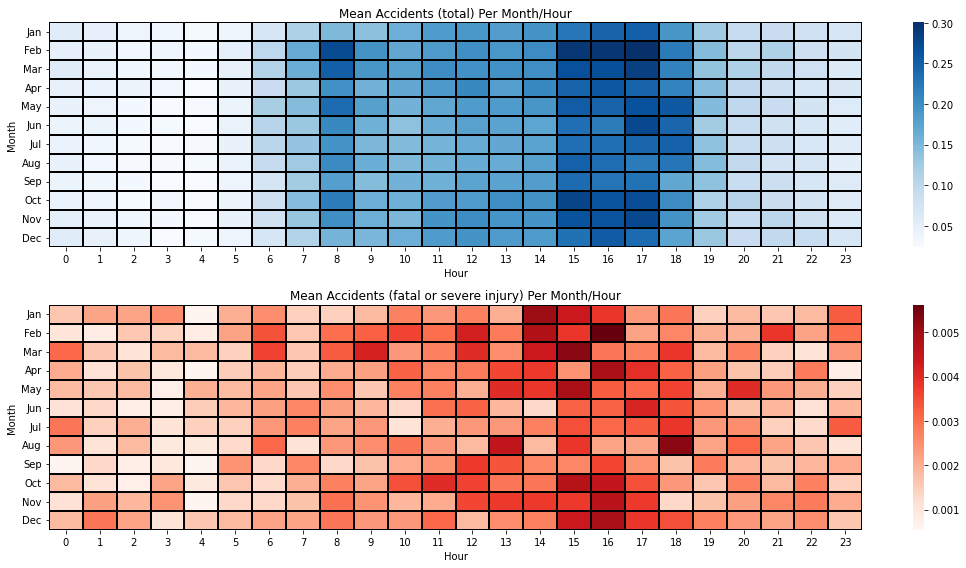

In [22]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
number_of_months = 12*(accident_df['ACCIDENTDATE'].max() - accident_df['ACCIDENTDATE'].min()) / np.timedelta64(1, 'Y')

# creating monthly mean chart for all accidents
month_time_df = accident_df.groupby([accident_df['ACCIDENTDATE'].dt.month, 
                                   accident_df['ACCIDENTTIME'].dt.hour], as_index=False).size().pivot(
    columns='ACCIDENTTIME', index='ACCIDENTDATE')
month_time_df.columns = month_time_df.columns.droplevel(0)
month_time_df.rename(index = dict(zip(range(1, 13), month_list)), inplace=True)
month_time_df = month_time_df.divide(month_lengths, axis=0) / number_of_months
# month_time_df = month_time_df / number_of_weeks

# creating monthly mean chart for fatal accidents
severe_month_time_df = accident_df[accident_df['SEVERITY']==1].groupby([accident_df['ACCIDENTDATE'].dt.month, 
                                   accident_df['ACCIDENTTIME'].dt.hour], as_index=False).size().pivot(
    columns='ACCIDENTTIME', index='ACCIDENTDATE')
severe_month_time_df.columns = severe_month_time_df.columns.droplevel(0)
severe_month_time_df.rename(index = dict(zip(range(1, 13), month_list)), inplace=True)
severe_month_time_df = severe_month_time_df.divide(month_lengths, axis=0) / number_of_months
# severe_month_time_df = severe_month_time_df / number_of_weeks

# plotting heatmaps for the charts
fig, ax = plt.subplots(2,1,figsize=(15,8))
sns.heatmap(month_time_df, cmap=plt.cm.Blues, linewidths=0.2, linecolor='black', ax=ax[0]);
sns.heatmap(severe_month_time_df, cmap=plt.cm.Reds, linewidths=0.2, linecolor='black', ax=ax[1]);
ax[0].set_xlabel('Hour'); ax[0].set_ylabel('Month'); 
ax[1].set_xlabel('Hour'); ax[1].set_ylabel('Month');
ax[0].set_title('Mean Accidents (total) Per Month/Hour'); 
ax[1].set_title('Mean Accidents (fatal or severe injury) Per Month/Hour'); 
fig.tight_layout()
plt.savefig('../figs/accidents_per_hour_month.png')

#### Notes
- The early evening has more accidents around winter - probably due to light conditions.
- At the same time, late afternoon has more accidents in summer. Some contributing factors could be glare, fatigue, people taking holidays...

### Distribution of number of people and number of vehicles

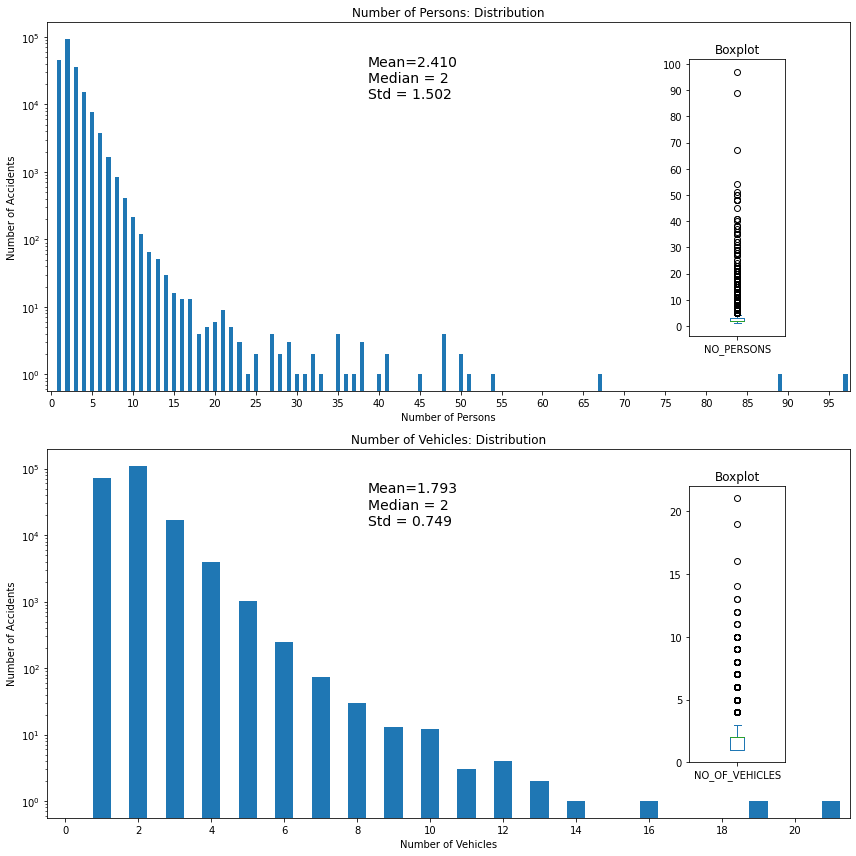

In [23]:
# how many people per accident?
person_count = accident_df['NO_PERSONS'].value_counts()
for value in range(person_count.index.max()):
    if value not in person_count.index:
        person_count[value] = 0
person_count.sort_index(inplace=True)
person_count_stats = accident_df['NO_PERSONS'].agg(['mean', 'median', 'std'])

# how many vehicles per accident?
vehicle_count = accident_df['NO_OF_VEHICLES'].value_counts()
for value in range(vehicle_count.index.max()):
    if value not in vehicle_count.index:
        vehicle_count[value] = 0
vehicle_count.sort_index(inplace=True)
vehicle_count_stats = accident_df['NO_OF_VEHICLES'].agg(['mean', 'median', 'std'])

fig, ax = plt.subplots(2, 1, figsize=(12,12))

# person count distribution
person_count.plot(kind='bar', ax=ax[0])
ax[0].set_yscale('log');
ax[0].set_xticks(person_count.index[::5]);
ax[0].set_xticklabels(ax[0].get_xticks(), rotation=0)
plot_text = f'''Mean={person_count_stats["mean"]:.3f}
Median = {person_count_stats["median"]:.0f}
Std = {person_count_stats["std"]:.3f}
'''
ax[0].text(x=0.4, y=0.75, s=plot_text, transform=ax[0].transAxes, fontsize=14);
ax[0].set_xlabel('Number of Persons');
ax[0].set_ylabel('Number of Accidents');
ax[0].set_title('Number of Persons: Distribution');
ins = ax[0].inset_axes([0.8, 0.15, 0.12, 0.75]);
ins.set_yticks(np.arange(0,101,10));
ins.set_title('Boxplot');
accident_df['NO_PERSONS'].plot(kind='box', ax=ins)

# vehicle count distribution
vehicle_count.plot(kind='bar', ax=ax[1])
ax[1].set_yscale('log');
ax[1].set_xticks(vehicle_count.index[::2]);
ax[1].set_xticklabels(ax[1].get_xticks(), rotation=0)
plot_text = f'''Mean={vehicle_count_stats["mean"]:.3f}
Median = {vehicle_count_stats["median"]:.0f}
Std = {vehicle_count_stats["std"]:.3f}
'''
ax[1].text(x=0.4, y=0.75, s=plot_text, transform=ax[1].transAxes, fontsize=14);
ax[1].set_xlabel('Number of Vehicles');
ax[1].set_ylabel('Number of Accidents');
ax[1].set_title('Number of Vehicles: Distribution');
ins = ax[1].inset_axes([0.8, 0.15, 0.12, 0.75]);
ins.set_yticks(np.arange(0,21,5));
ins.set_title('Boxplot');
accident_df['NO_OF_VEHICLES'].plot(kind='box', ax=ins)

fig.tight_layout()
plt.savefig('../figs/person_vehicle_dist.png')

### Age

Age distribution of all persons and of drivers

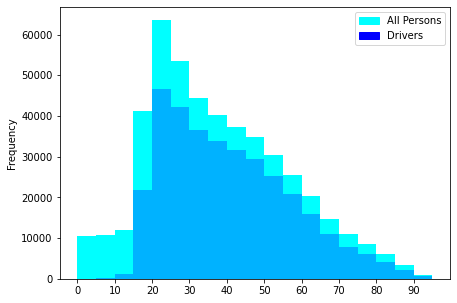

In [24]:
fig, ax = plt.subplots(figsize=(7,5))

person_df['AGE'].plot.hist(grid=False, bins=np.arange(0,100,5), ax=ax, color='cyan');
person_df[person_df['SEATING_POSITION']=='D ']['AGE'].plot.hist(grid=False, bins=np.arange(0,100,5), ax=ax, 
                                                                color='blue', alpha=0.3);
ax.set_xticks(np.arange(0,100,10))
ax.legend(handles=[plt.Rectangle((0, 1), 0.1, 0.3, color='cyan'), plt.Rectangle((0, 0.5), 0.1, 0.3, color='blue')],
         labels=['All Persons', 'Drivers']);
plt.savefig('../figs/age_dist.png')

Age distribution per severity. Also included mean speed zone per severity

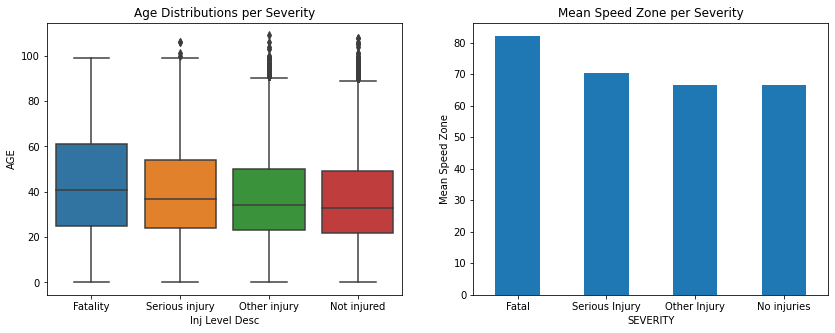

In [25]:
accident_test = accident_df.copy()
accident_test.loc[accident_test['SPEED_ZONE']>110, 'SPEED_ZONE'] = None
speed_df_plot = accident_test.groupby('SEVERITY')['SPEED_ZONE'].mean()
speed_df_plot.rename(index={1:'Fatal', 2:'Serious Injury', 3:'Other Injury', 4:'No injuries'}, inplace=True)

age_df_plot = person_df[person_df['Inj Level Desc']!='Unknown']

fig, ax = plt.subplots(1 ,2, figsize=(14,5))

sns.boxplot(x='Inj Level Desc', y='AGE', data=age_df_plot, ax=ax[0],
            order=['Fatality', 'Serious injury', 'Other injury', 'Not injured']);
ax[0].set_title('Age Distributions per Severity');

speed_df_plot.plot.bar(ax=ax[1]);
ax[1].set_ylabel('Mean Speed Zone');
ax[1].set_title('Mean Speed Zone per Severity');
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0);
plt.savefig('../figs/age_speed_per_sev.png')

### Vehicle make: level of damage vs severity of accident
Recall that severity is assessed in terms of injuries, so we are curious to see if the car makes that sustain less damage also protect their passengers better.

Answer: the correlation is too weak to be meaningful

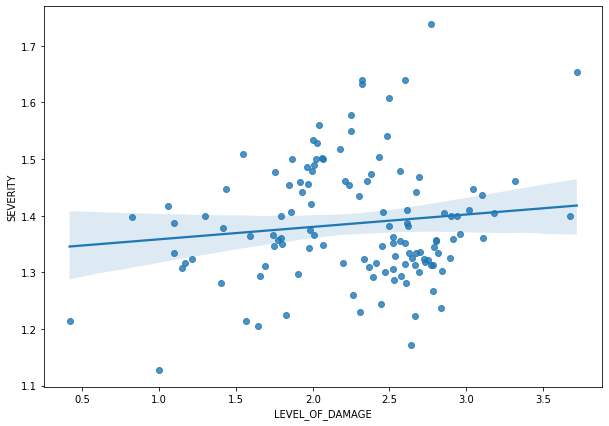

In [26]:
# creating vehicle level of damage vs severiy table
accident_test_data = accident_df[['ACCIDENT_NO', 'SEVERITY']]
vehicle_test_df = vehicle_df.merge(accident_test_data, on='ACCIDENT_NO')

# in level of damage, 6 means nil and 9 means unknown, so we'll replace them
vehicle_test_df.replace({6: 0, 9: None}, inplace=True)

# aggregating means for damage and severity
vehicle_df_plot = vehicle_test_df.groupby('VEHICLE_MAKE').agg({'LEVEL_OF_DAMAGE': np.mean, 'SEVERITY': np.mean})

# filtering out rare makes
vehicle_make_filter = vehicle_df['VEHICLE_MAKE'].value_counts()[vehicle_df['VEHICLE_MAKE'].value_counts()>20].index
vehicle_df_plot = vehicle_df_plot[vehicle_df_plot.index.isin(vehicle_make_filter)]

# severity 1 is most severe and 4 is least, but that will make the plot confusing, so just this one time we'll invert the colum
vehicle_df_plot['SEVERITY'] = 4 - vehicle_df_plot['SEVERITY']

fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(data=vehicle_df_plot, x='LEVEL_OF_DAMAGE', y='SEVERITY');
plt.savefig('../figs/vehicle_make_damage_sev.png')

### Interactions with severity for degree of urbanism, atmospheric condition and event type
For each of these we'll create a bar plot per severity, and we'll also create a heatmap of the actual proportion of each severity compared to its expectation. 

We'll calculate the expected values using scipy's chi2_contingency function

In [27]:
# getting degree of urbanism and severity interaction
accident_test_data = accident_df[['ACCIDENT_NO', 'SEVERITY', 'SPEED_ZONE']]
node_test = node_df.merge(accident_test_data, on='ACCIDENT_NO')
du_sev_cross = node_test.groupby('DEG_URBAN_NAME')['SEVERITY'].value_counts().unstack()
du_sev_cross.drop(4, axis=1, inplace=True)`
du_sev_cross.rename(columns={1: 'Fatal', 2: 'Serious Injury', 3: 'Other injury'}, inplace=True)
du_sev_cross = du_sev_cross.reindex(['MELBOURNE_CBD', 'MELB_URBAN', 'LARGE_PROVINCIAL_CITIES', 'SMALL_CITIES', 
                                     'TOWNS', 'SMALL_TOWNS', 'RURAL_VICTORIA'])
du_sev_chi2_res = st.chi2_contingency(du_sev_cross)
du_sev_exp_diff = pd.DataFrame(du_sev_cross.values / du_sev_chi2_res[3], 
                               index=du_sev_cross.index, columns=du_sev_cross.columns)

# getting atmospheric condition and severity interaction
accident_test_data = accident_df[['ACCIDENT_NO', 'SEVERITY', 'NO_OF_VEHICLES']]
atmospheric_test = atmospheric_cond_df.merge(accident_test_data, on='ACCIDENT_NO')
atm_sev_cross = atmospheric_test.groupby('Atmosph Cond Desc')['SEVERITY'].value_counts().unstack()
atm_sev_cross = atm_sev_cross.drop(4, axis=1).fillna(0)
atm_sev_cross.rename(columns={1: 'Fatal', 2: 'Serious Injury', 3: 'Other injury'}, inplace=True)
atm_sev_chi2_res = st.chi2_contingency(atm_sev_cross)
atm_sev_exp_diff = pd.DataFrame(atm_sev_cross / atm_sev_chi2_res[3], 
                                index=atm_sev_cross.index, columns=atm_sev_cross.columns)

# getting event_type and severity interaction
accident_test_data = accident_df[['ACCIDENT_NO', 'SEVERITY', 'NO_OF_VEHICLES']]
event_test = accident_event_df[~accident_event_df['Event Type Desc'].isin(['Unknown', 'Not known', 'Not applicable'])].merge(
    accident_test_data, on='ACCIDENT_NO')
type_sev_cross = event_test.groupby('Event Type Desc')['SEVERITY'].value_counts().unstack()
type_sev_cross = type_sev_cross.drop(4, axis=1).fillna(0)
type_sev_cross.rename(columns={1: 'Fatal', 2: 'Serious Injury', 3: 'Other injury'}, inplace=True)
type_sev_chi2_res = st.chi2_contingency(type_sev_cross)
type_sev_exp_diff = pd.DataFrame(type_sev_cross / type_sev_chi2_res[3], 
                                index=type_sev_cross.index, columns=type_sev_cross.columns)


fig, ax = plt.subplots(3, 2, figsize=(15,20))

# plotting for degree of urbanism
du_sev_cross.plot(kind='bar', ax=ax[0][0]);
ax[0][0].set_yscale('log');
ax[0][0].set_title('Number of Accidents per Degree of Urbanism');
sns.heatmap(du_sev_exp_diff, cmap=plt.cm.bwr, ax=ax[0][1], vmin=0, center=1, 
            cbar_kws={'label': 'Proportion of Expectated Number'});
cbar = ax[0][1].collections[0].colorbar;
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0));
fig.tight_layout();
ax[0][1].set_title('Actual Number of Accidents Compared to Expected Number');

# plotting for atmospheric conditions
atm_sev_cross.plot(kind='bar', ax=ax[1][0]);
ax[1][0].set_yscale('log');
ax[1][0].set_title('Number of Accidents per Atmospheric Condition');
sns.heatmap(atm_sev_exp_diff, cmap=plt.cm.bwr, ax=ax[1][1], vmin=0, center=1, 
            cbar_kws={'label': 'Proportion of Expectated Number'});
cbar = ax[1][1].collections[0].colorbar;
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0));
fig.tight_layout();
ax[1][1].set_title('Actual Number of Accidents Compared to Expected Number');

# plotting for event type
type_sev_cross.plot(kind='bar', ax=ax[2][0]);
ax[2][0].set_yscale('log');
ax[2][0].set_title('Number of Accidents per Event Type');
sns.heatmap(type_sev_exp_diff, cmap=plt.cm.bwr, ax=ax[2][1], vmin=0, center=1, 
            cbar_kws={'label': 'Proportion of Expectated Number'});
cbar = ax[2][1].collections[0].colorbar;
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0));
ax[2][1].set_title('Actual Number of Accidents Compared to Expected Number');

fig.tight_layout();
plt.savefig('../figs/du_atm_type_sev_interaction.png')

SyntaxError: invalid syntax (950233745.py, line 5)

#### Notes
- Rural Victoria has the second most accidents and is also by far the most lethal per accident. In general, the more urban the environment the less likely an accident is to be fatal or to cause serious harm
- Snow and rain decrease fatality rate, presumably because drivers drive more slowly. On the other hand, fog and smoke increase fatality rate. Perhaps visibility is a more important factor than road conditions for accident severity.
- The main thing you don't want to do is run off the road. Collisions are actually less fatal than expected, though these are probably highly dependent on speeds.

Are fog and smoke more conducive to fatalities because they cause more pileups? 

If we check the distribution of number of vehicles for different atmospheric conditions, that doesn't appear to be the case.

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

atmospheric_test.boxplot(column='NO_OF_VEHICLES', by='Atmosph Cond Desc', ax=ax)
# atm_no_vehicles.plot.barh()

#### Nodes total accidents vs severity rate
Severity rate = (fatal accidents + serious injury accidents) / total accidents

Looking only at top 1000 nodes without top two outliers to get clearer picture

In [ ]:
node_test = accident_df.groupby('NODE_ID')['SEVERITY'].value_counts().unstack()
node_test.drop(4, axis=1, inplace=True)
node_test.fillna(0, inplace=True)
node_test.rename(columns={1: 'Fatal', 2: 'Serious Injury', 3: 'Other Injury'}, inplace=True)
node_test['Total'] = node_test.T.sum()
node_test['Severity rate'] = (node_test['Fatal'] +  node_test['Serious Injury']) / node_test['Total']

node_test = node_test.sort_values('Total', ascending=False).iloc[2:1000, :]
node_test = pd.concat([node_test,node_df[['DEG_URBAN_NAME', 'Lat', 'Long']]], axis=1)

fig, ax = plt.subplots(figsize=(10,7))
sns.regplot(data=node_test, x='Total', y='Severity rate', ax=ax, scatter_kws={'alpha': 0.25});
plt.savefig('../figs/node_total_sev.png')

### Correlations between types of injuries
Here we took the number of people per accident with each type of injury (fatality, serious injury, other injury) and created a 2D histogram of their intersections.

We also calculate Spearman Rank correlation to get a quantitative measure of the interaction

The reader may choose which correlation he/she wishes to see. If the same column is chosen in both fields, a simple histogram is shown

In [ ]:
labels = ['NO_PERSONS_NOT_INJ', 'NO_PERSONS_INJ_2', 'NO_PERSONS_INJ_3', 'NO_PERSONS_KILLED']
@ipywidgets.interact(
    xlabel = ipywidgets.Dropdown(options = labels),
    ylabel = ipywidgets.Dropdown(options = labels)
)
def injury_corr_plot(xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10,7))
    
    if xlabel==ylabel:
        x = accident_df[xlabel]
        x.hist(ax=ax, grid=False, bins=np.arange(0,x.max(),1))
        ax.set_yscale('log')
    else:
        x, y = accident_df[xlabel], accident_df[ylabel]
        xrange, yrange = np.arange(1,np.quantile(x, 0.99999),1), np.arange(1,np.quantile(y,0.99999),1)
        h = ax.hist2d(x, y, bins=(xrange, yrange), norm=mpl.colors.LogNorm(), cmap=plt.cm.Reds);
        ax.set_xticklabels(xrange[::max(1,int(xrange.max()/12))]-1)
        ax.set_yticklabels(yrange[::max(1,int(yrange.max()/12))]-1)
        ax.set_xlabel(xlabel);
        ax.set_ylabel(ylabel);
        fig.colorbar(h[3], ax=ax);
        
        spearmanr = st.spearmanr(x,y)
        ax.text(0.3, 0.92, f'Spearman R = {spearmanr[0]:.2f}; P-value = {spearmanr[1]:.2f}', transform=ax.transAxes, fontsize=16)
    
    plt.show()

### Further analysis
Some more options to explore in the future
1. Gather population data to be able to understand the time and location analyses in context
2. Look into fields we didn't cover and their interaction with severity and fatality. Examples of fields that could be interesting: road type, driver intent, collision points, seating positions.
3. Employ clustering algorithms to find hidden structure; perhaps visualize using TSNE 